In [1]:
import sys
sys.path.append('../input-archives/TensorFlow/models/research')
sys.path.append('../src')

In [2]:
from vipir.vipir import vipir as vp
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display

In [3]:
from vipir.vipir import get_cdf

In [4]:
wi937 = get_cdf('WI937','2020198193002')

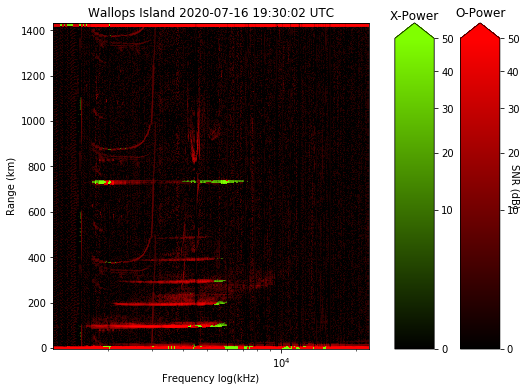

In [5]:
fig = plt.figure(figsize=(8,6))
ax = wi937.plot_pwr(fig)

In [6]:
import matplotlib.patches as patches
def draw_box_on_axis(ax, l_left=None, xext=None, yext=None, bbox=None,
                    label=None, color='red', linestyle='-',linewidth=3):
    
    if bbox is not None:
        ll_left =  (bbox['freqstart'], bbox['rngstart'])
        l_xext = bbox['freqend']-bbox['freqstart']
        l_yext = bbox['rngend']-bbox['rngstart']
    else:
        ll_left = l_left
        l_xext = xext
        l_yext = yext
        

    r = patches.Rectangle( ll_left, l_xext, l_yext, facecolor='none',
                      edgecolor= color, linestyle=linestyle, linewidth=linewidth, label=label)

    ax.add_patch(r)

In [7]:
cdf = vp(r"../data/netcdf/WI937_2020004132603.NGI")

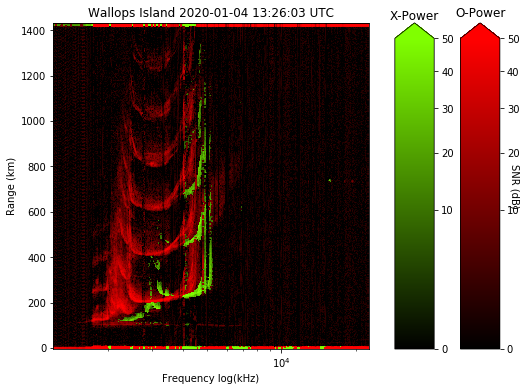

In [8]:
fig = plt.figure(figsize=(8,6))
ax = cdf.plot_pwr(fig)

In [9]:
bbox = cdf.get_trace_bbox()
bbox

{'freqstart': 1702.91,
 'freqend': 5263.882,
 'rngstart': 115.41595,
 'rngend': 380.73227}

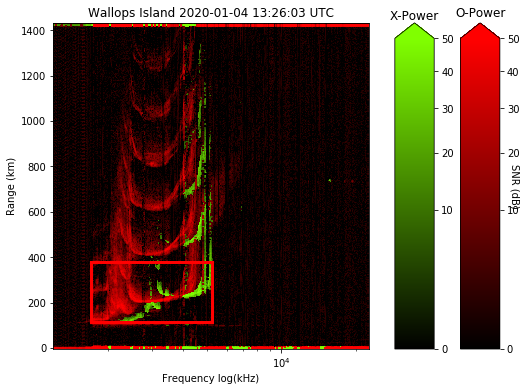

In [10]:
fig = plt.figure(figsize=(8,6))
ax = cdf.plot_pwr(fig)
draw_box_on_axis(ax, bbox=bbox)

In [11]:
from ftplib import FTP
import os

In [12]:
#ftp://ftp.ngdc.noaa.gov/ionosonde/data/WI937/individual/2020/198/ionogram/
#ftp://ftp.ngdc.noaa.gov/ionosonde/data/WI937/individual/2020/198/ionogram/WI937_2020198000603.NGI

In [13]:
from datetime import datetime, timezone

In [14]:
dt = datetime(2020,
                      7, 21,0,6,3, tzinfo=timezone.utc)

In [15]:
xx='2020-07-18 16:42:04'

In [16]:
type(xx)

str

In [17]:
datetime.fromisoformat(xx)

datetime.datetime(2020, 7, 18, 16, 42, 4)

In [18]:
dt.timetuple().tm_yday

203

In [19]:
dt.toordinal()

737627

In [20]:
#ftp://ftp.ngdc.noaa.gov/ionosonde/data/WI937/individual/2020/198/ionogram/WI937_2020198000603.NGI

import tempfile
from ftplib import FTP

def get_cdf(stn,dtstr, ftpsite ='ftp.ngdc.noaa.gov', rootdir='/ionosonde/data'):
    """
    Returns a vip for a station and date-time string
    """
    yr = dtstr[0:4]
    daynum=dtstr[4:7]
    
    path = f'{rootdir}/{stn}/individual/{yr}/{daynum}/ionogram/{stn}_{dtstr}.NGI'
    
    # create a temp file to fetch the cdf into
    fh =  tempfile.mkstemp()

    #fetch the cdf
    with open(fh[1],'wb') as fout:
        with FTP(ftpsite) as ftp:
            ftp.login()
            ftp.retrbinary(f'RETR {path}', fout.write)
            
    # read up as a vip what we just fetched        
    vip = vp(fh[1])
    
    #ditch the temp file
    os.remove(fh[1])
    
    return vip


In [21]:
#ftp://ftp.ngdc.noaa.gov/ionosonde/data/WI937/individual/2020/198/ionogram/WI937_2020198193002.NGI

In [22]:
from vipir.vipir import get_cdf

In [23]:
wi937 = get_cdf('WI937','2020198193002')

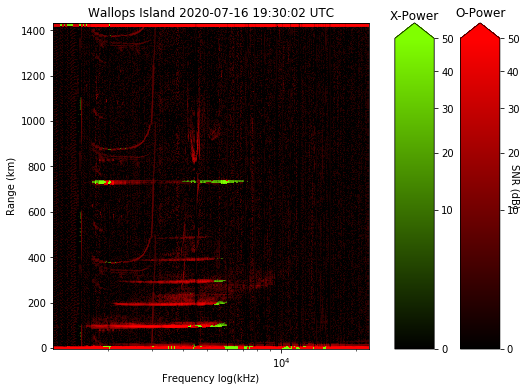

In [24]:
fig = plt.figure(figsize=(8,6))
wi937.plot_pwr(fig)
#bbox = wi937.get_trace_bbox()
#draw_box_on_axis(ax, (bbox['freqstart'], bbox['rngstart']),
#                 bbox['freqend']-bbox['freqstart'],
#                 bbox['rngend']-bbox['rngstart'])

In [25]:
wi937_1 = get_cdf('WI937','2020198193002')

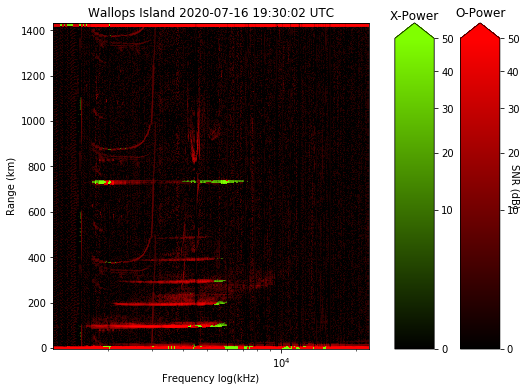

In [26]:
fig = plt.figure(figsize=(8,6))
wi937_1.plot_pwr(fig)

In [27]:
from datetime import datetime, timezone, timedelta
def obsname_todt(obsname:str) -> datetime:
    year = int(obsname[6:10])
    daynum = int(obsname[10:13]) # day of the year
    hr = int(obsname[13:15])
    min = int(obsname[15:17])
    sec = int(obsname[17:19])
    
    #construct the dt by starting at January 1 then advance daynum number of days.
    dt = datetime(year, 1,1, hr, min, sec,tzinfo=timezone.utc )+timedelta(days = daynum-1)
    
    return dt

In [28]:
#ftp://ftp.ngdc.noaa.gov/ionosonde/data/WI937/individual/2020/198/ionogram/WI937_2020198000603.NGI

import re
from ftplib import FTP

def get_vipir(stn:str, obstime:str,ftpsite ='ftp.ngdc.noaa.gov', rootdir='/ionosonde/data'):
    
    #hope this works, obstime must by 'yyyy-mm-dd hh:mm:ss.s'
    dt = datetime.fromisoformat(obstime)
    dt = dt.replace(tzinfo=timezone.utc)
    
    yr = dt.year
    daynum =  dt.timetuple().tm_yday
    
    dir = f'{rootdir}/{stn}/individual/{yr}/{daynum}/ionogram/'
    #get the obs for the day
    with FTP(ftpsite) as ftp:
        ftp.login()
        ftp.cwd(dir)
        obs_list = [f for f in ftp.nlst() if re.search(r'^.*.NGI$',f)]
        
    #get the times out of the file names
    obs_times = np.array([obsname_todt(o) for o in obs_list])
    
    #get the observation that's closest to obstime
    deltas = np.abs(dt - obs_times)
    closest = deltas.argmin()
    
    return obs_list[closest][6:19] # just the encoded datestring
    
        

In [29]:
 get_vipir('WI937','2020-06-15 13:57:45')

'2020167135803'

In [30]:
# seven hours at Wallops
obs_times = ['2020-06-20 00:00:00', '2020-06-20 01:00:00', '2020-06-20 02:00:00',
             '2020-06-20 03:00:00', '2020-06-20 04:00:00', '2020-06-20 05:00:00',
             '2020-06-20 06:00:00']
obs_names = [get_vipir('WI937', ot) for ot in obs_times]
obs={}
for o in obs_names:
    obs[o] = get_cdf('WI937', o)

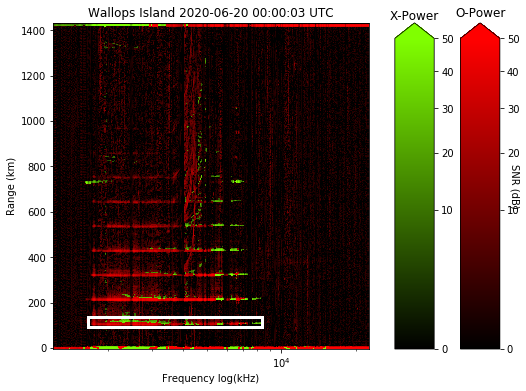

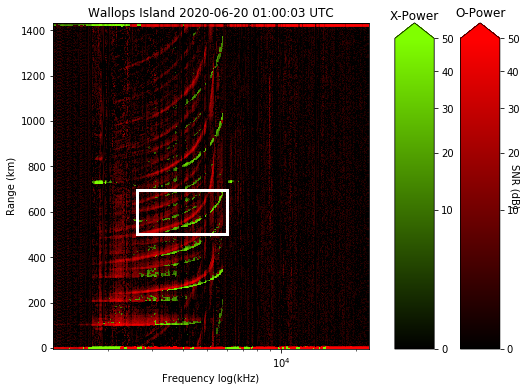

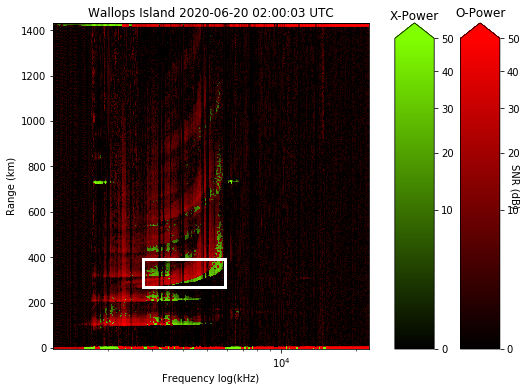

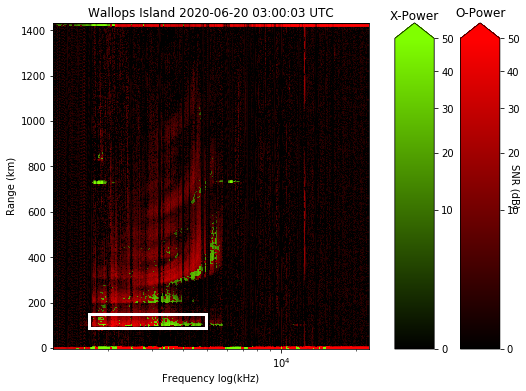

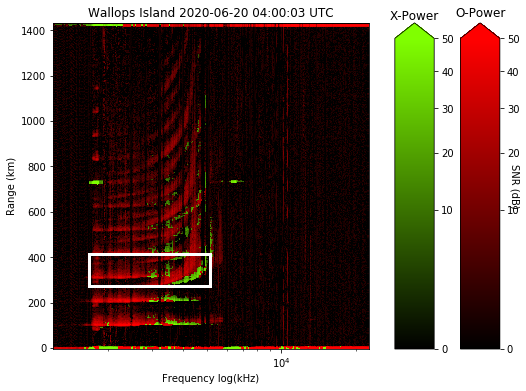

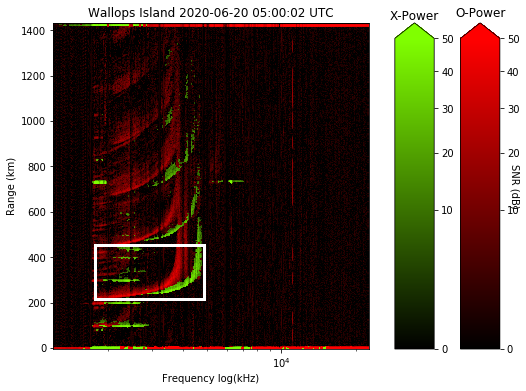

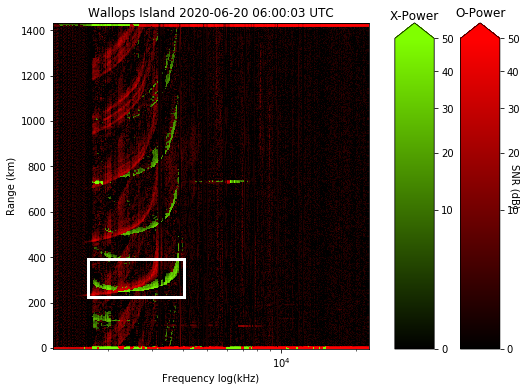

In [31]:
for v in obs:
    fig = plt.figure(figsize=(8,6))
    ax = obs[v].plot_pwr(fig)
    draw_box_on_axis(ax, bbox = obs[v].get_trace_bbox(size=11), color='white')

In [32]:
obs.keys()

dict_keys(['2020172000003', '2020172010003', '2020172020003', '2020172030003', '2020172040003', '2020172050002', '2020172060003'])

In [33]:
import pandas as pd
pd.DataFrame({'ObsTime':[obs[o].obs_time.isoformat() for o in obs_names],
             'SolarTime':[(obs[o].obs_time+timedelta(hours=obs[o].station_location['longitude']/15.0)).isoformat()\
             for o in obs_names]})

,ObsTime,SolarTime
0,2020-06-20T00:00:03+00:00,2020-06-19T18:58:08.280762+00:00
1,2020-06-20T01:00:03+00:00,2020-06-19T19:58:08.280762+00:00
2,2020-06-20T02:00:03+00:00,2020-06-19T20:58:08.280762+00:00
3,2020-06-20T03:00:03+00:00,2020-06-19T21:58:08.280762+00:00
4,2020-06-20T04:00:03+00:00,2020-06-19T22:58:08.280762+00:00
5,2020-06-20T05:00:02+00:00,2020-06-19T23:58:07.280762+00:00
6,2020-06-20T06:00:03+00:00,2020-06-20T00:58:08.280762+00:00


## file names within a date range

In [34]:
from datetime import datetime, timezone, timedelta
def obsname_todt(obsname:str) -> datetime:
    year = int(obsname[6:10])
    daynum = int(obsname[10:13]) # day of the year
    hr = int(obsname[13:15])
    min = int(obsname[15:17])
    sec = int(obsname[17:19])
    
    dt = datetime(year, 1,1, hr, min, sec,tzinfo=timezone.utc )+timedelta(daynum-1)
    
    return dt

In [35]:


def get_flist(stn, fromstr, tostr, interval = timedelta(minutes=10),
              ftpsite ='ftp.ngdc.noaa.gov',rootdir='/ionosonde/data'):
    """
    fromstr and tostr are utc in iso format
    """
    
    #convert fromstr and tostr to UTC  datetime objects
    fromdt = datetime.fromisoformat(fromstr)
    fromdt = fromdt.replace(tzinfo=timezone.utc)  
    todt = datetime.fromisoformat(tostr)
    todt = todt.replace(tzinfo=timezone.utc)

    #set up ftp connection
    ftp = FTP(ftpsite)
    ftp.login()
    
    #loop over the days and accumulate the qualifying file names
    lastdt = thisdt = fromdt
    flist = []
    try:
        while thisdt <= todt:

            #change to the data directory for the current day
            yr = thisdt.year
            daynum =  thisdt.timetuple().tm_yday
            dir = f'{rootdir}/{stn}/individual/{yr}/{daynum:03}/ionogram/'
            ftp.cwd(dir)

            #get the NGI files and extract their date time from their names
            obs_list = [f for f in ftp.nlst() if re.search(r'^.*.NGI$',f)]
            obs_list.sort() # make sure in lexo/chrono order
            # get the datetimes from the file names
            obs_dt = [obsname_todt(o) for o in obs_list]

            #filter the file name list to be between fromdt and todt
            obs_all = [(f,o) for f,o in zip(obs_list,obs_dt) if o >= fromdt and o <= todt]
            
            #space out by the interval
            #find the next file that is at least 'interval' later than its predecessor
            obs_list = []
            for oa in obs_all:
                if (oa[1]-lastdt) >= interval:
                    obs_list.append((oa[1].strftime('%Y-%m-%d %H:%M:%S'), dir + oa[0]))
                    lastdt = oa[1]

            #accumulate the filtered file names
            flist += obs_list

            #see what tomorrow brings
            thisdt += timedelta(days=1)
    
    finally:
        ftp.close()
    
    return flist
        


In [36]:
obslist=get_flist('WI937','2020-06-30 12:00', '2020-07-01 18:00', interval=timedelta(hours=1))

In [37]:
obslist

[('2020-06-30 13:00:03',
  '/ionosonde/data/WI937/individual/2020/182/ionogram/WI937_2020182130003.NGI'),
 ('2020-06-30 14:02:03',
  '/ionosonde/data/WI937/individual/2020/182/ionogram/WI937_2020182140203.NGI'),
 ('2020-06-30 15:02:03',
  '/ionosonde/data/WI937/individual/2020/182/ionogram/WI937_2020182150203.NGI'),
 ('2020-06-30 16:02:03',
  '/ionosonde/data/WI937/individual/2020/182/ionogram/WI937_2020182160203.NGI'),
 ('2020-06-30 17:02:03',
  '/ionosonde/data/WI937/individual/2020/182/ionogram/WI937_2020182170203.NGI'),
 ('2020-06-30 18:02:03',
  '/ionosonde/data/WI937/individual/2020/182/ionogram/WI937_2020182180203.NGI'),
 ('2020-06-30 19:04:03',
  '/ionosonde/data/WI937/individual/2020/182/ionogram/WI937_2020182190403.NGI'),
 ('2020-06-30 20:06:03',
  '/ionosonde/data/WI937/individual/2020/182/ionogram/WI937_2020182200603.NGI'),
 ('2020-06-30 21:08:02',
  '/ionosonde/data/WI937/individual/2020/182/ionogram/WI937_2020182210802.NGI'),
 ('2020-06-30 22:08:02',
  '/ionosonde/data/WI

In [40]:
xx = get_cdf('WI937', path=obslist[1][1])

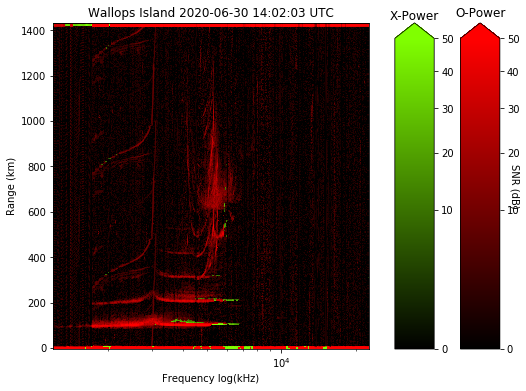

In [42]:
fig = plt.figure(figsize=(8,6))
xx.plot_pwr(fig)